In [47]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd # Added for submission file
from skimage.color import rgb2hsv # Added for new features
from skimage.morphology import opening, closing, disk # Added for mask cleanup

In [48]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=img.dtype)
        gt_img_3c[:, :, 0] = gt_img
        gt_img_3c[:, :, 1] = gt_img
        gt_img_3c[:, :, 2] = gt_img
        cimg = np.concatenate((img, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

In [49]:
root_dir = "training/" # Ensure this directory exists and contains 'images' and 'groundtruth' subdirectories

image_dir = os.path.join(root_dir, "images/")
gt_dir = os.path.join(root_dir, "groundtruth/")

if not os.path.exists(image_dir) or not os.path.exists(gt_dir):
    print(f"Error: Ensure '{image_dir}' and '{gt_dir}' exist.")
    # You might want to stop execution here if directories are missing
    sys.exit()
else:
    files = sorted(os.listdir(image_dir)) # Sort to ensure consistent order
    gt_files = sorted(os.listdir(gt_dir))

    # Filter out non-image files if any and ensure corresponding ground truth exists
    valid_files = [f for f in files if os.path.exists(os.path.join(gt_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff'))]

    if not valid_files:
        print("No valid image files found in 'images' with corresponding ground truth files.")
        sys.exit()
    else:
        # Load maximum 100 images, or fewer if not available
        n = min(100, len(valid_files))
        print(f"Loading {n} images and their ground truths...")

        imgs = [load_image(os.path.join(image_dir, valid_files[i])) for i in range(n)]
        gt_imgs = [load_image(os.path.join(gt_dir, valid_files[i])) for i in range(n)]
        
        # Store the filenames being used, helpful for debugging later
        loaded_filenames = valid_files[:n]
        print(f"Loaded images: {loaded_filenames}")


Loading 100 images and their ground truths...
Loaded images: ['satImage_001.png', 'satImage_002.png', 'satImage_003.png', 'satImage_004.png', 'satImage_005.png', 'satImage_006.png', 'satImage_007.png', 'satImage_008.png', 'satImage_009.png', 'satImage_010.png', 'satImage_011.png', 'satImage_012.png', 'satImage_013.png', 'satImage_014.png', 'satImage_015.png', 'satImage_016.png', 'satImage_017.png', 'satImage_018.png', 'satImage_019.png', 'satImage_020.png', 'satImage_021.png', 'satImage_022.png', 'satImage_023.png', 'satImage_024.png', 'satImage_025.png', 'satImage_026.png', 'satImage_027.png', 'satImage_028.png', 'satImage_029.png', 'satImage_030.png', 'satImage_031.png', 'satImage_032.png', 'satImage_033.png', 'satImage_034.png', 'satImage_035.png', 'satImage_036.png', 'satImage_037.png', 'satImage_038.png', 'satImage_039.png', 'satImage_040.png', 'satImage_041.png', 'satImage_042.png', 'satImage_043.png', 'satImage_044.png', 'satImage_045.png', 'satImage_046.png', 'satImage_047.png'

Image: satImage_001.png
Image size = 400, 400


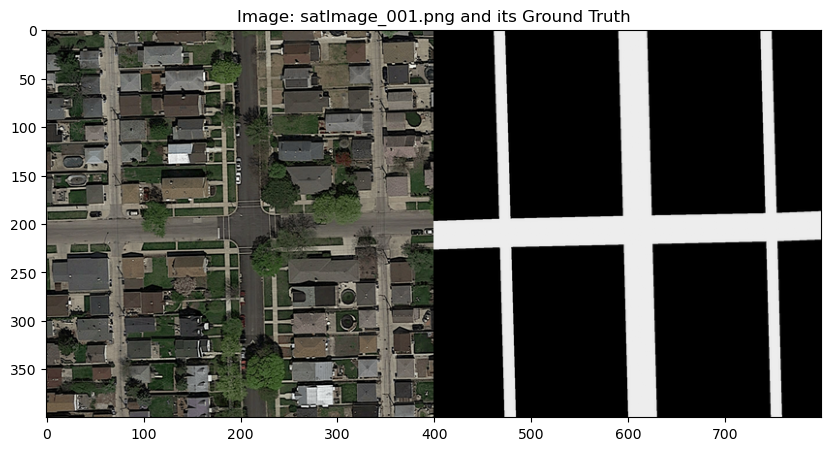

In [50]:
if 'imgs' in locals() and len(imgs) > 0:
    print(f"Image: {loaded_filenames[0]}")
    print(f"Image size = {imgs[0].shape[0]}, {imgs[0].shape[1]}")

    # Show first image and its groundtruth image
    cimg = concatenate_images(imgs[0], gt_imgs[0])
    fig1 = plt.figure(figsize=(10, 10))
    plt.imshow(cimg) # cmap="Greys_r" is often good for single channel, but concatenate_images tries to make it 3-channel
    plt.title(f"Image: {loaded_filenames[0]} and its Ground Truth")
    plt.show()
else:
    print("No images loaded to display.")

In [51]:
patch_size = 16  # each patch is 16*16 pixels

if 'imgs' in locals() and len(imgs) > 0:
    img_patches_list = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
    gt_patches_list = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

    img_patches = np.asarray([patch for sublist in img_patches_list for patch in sublist])
    gt_patches = np.asarray([patch for sublist in gt_patches_list for patch in sublist])
    print(f"Total number of {patch_size}x{patch_size} patches extracted: {len(img_patches)}")
else:
    print("No images loaded to extract patches from.")
    img_patches = np.array([])
    gt_patches = np.array([])

Total number of 16x16 patches extracted: 62500


In [52]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def extract_hsv_rgb_features(patch):
    """
    Extracts HSV and RGB features from an image patch.
    Ensures patch is uint8 0-255 for HSV conversion.
    """
    if patch.dtype != np.uint8: # Common if coming from mpimg.imread (float 0-1)
        if np.max(patch) <= 1.0 and np.min(patch) >=0.0 : # Check if it's float 0-1
            patch_uint8 = (patch * 255).astype(np.uint8)
        else: # If other float range, or already int but not uint8
            patch_uint8 = patch.astype(np.uint8) # Might need more robust normalization
    else:
        patch_uint8 = patch

    # Ensure patch is 3-channel for rgb2hsv
    if len(patch_uint8.shape) == 2: # Grayscale
        patch_rgb = np.stack((patch_uint8,)*3, axis=-1)
    elif patch_uint8.shape[2] == 1: # Single channel
        patch_rgb = np.concatenate([patch_uint8, patch_uint8, patch_uint8], axis=2)
    elif patch_uint8.shape[2] == 4: # RGBA, convert to RGB
        patch_rgb = patch_uint8[:,:,:3]
    else:
        patch_rgb = patch_uint8

    if patch_rgb.shape[0] == 0 or patch_rgb.shape[1] == 0: # Handle empty patches
        return np.zeros(12) # Return zero vector matching feature length

    hsv_patch = rgb2hsv(patch_rgb) # Expects RGB in range [0,1] or [0,255]
                                   # skimage.color.rgb2hsv handles uint8 [0-255] directly

    h_mean = np.mean(hsv_patch[:, :, 0])
    s_mean = np.mean(hsv_patch[:, :, 1])
    v_mean = np.mean(hsv_patch[:, :, 2])
    h_var = np.var(hsv_patch[:, :, 0])
    s_var = np.var(hsv_patch[:, :, 1])
    v_var = np.var(hsv_patch[:, :, 2])
    
    # RGB features (from original patch_rgb which is uint8)
    # Normalize to 0-1 for mean/var consistency if desired, or use as is.
    patch_rgb_float = patch_rgb.astype(float) / 255.0 
    rgb_mean = np.mean(patch_rgb_float, axis=(0, 1)) # Per channel mean
    rgb_var = np.var(patch_rgb_float, axis=(0, 1))   # Per channel var
    
    feature_vector = np.concatenate([
        [h_mean, s_mean, v_mean, h_var, s_var, v_var],
        rgb_mean, # This is 3 values
        rgb_var   # This is 3 values
    ]) # Total 6 + 3 + 3 = 12 features
    return feature_vector

print("New feature extractor 'extract_hsv_rgb_features' is defined (12 features).")

New feature extractor 'extract_hsv_rgb_features' is defined (12 features).


In [53]:
# --- Corrected Cell for Feature Extraction (formerly Cell 6) ---

# This function is for predicting on a new, full image
def extract_img_features(image_path, feature_extractor_func):
    """
    Loads an image, crops it into patches, and applies the given
    feature_extractor_func to each patch.
    """
    img = load_image(image_path)
    # Ensure image is in uint8 format 0-255 if loaded as float 0-1
    if img.dtype in [np.float32, np.float64] and np.max(img) <= 1.0:
        img = (img * 255).astype(np.uint8)

    patches = img_crop(img, patch_size, patch_size)
    features = np.asarray([feature_extractor_func(patch) for patch in patches])
    return features, patches, img

# You also need the definition for the feature extractor you chose.
# This is the numpy-only version from the last step.
def extract_rgb_features_numpy(patch):
    """
    Extracts mean and variance for each of the R, G, B channels.
    """
    # Ensure patch is 3-channel
    if len(patch.shape) == 2:
        patch_rgb = np.stack((patch,)*3, axis=-1)
    elif patch.shape[2] == 1:
        patch_rgb = np.concatenate([patch, patch, patch], axis=2)
    elif patch.shape[2] == 4:
        patch_rgb = patch[:,:,:3]
    else:
        patch_rgb = patch
    
    rgb_mean = np.mean(patch_rgb, axis=(0, 1))
    rgb_var = np.var(patch_rgb, axis=(0, 1))
    
    return np.concatenate([rgb_mean, rgb_var])

print("Corrected 'extract_img_features' and numpy-based feature extractor are defined.")

Corrected 'extract_img_features' and numpy-based feature extractor are defined.


In [54]:
if img_patches.size > 0:
    foreground_threshold = 0.25 

    def patch_to_label(patch):
        if len(patch.shape) == 3: # If ground truth is RGB, take mean (e.g. from one channel or avg)
            # Assuming road is represented by non-zero pixels in any channel,
            # or more robustly, if it's a grayscale image replicated across channels.
            patch_gray = np.mean(patch, axis=2) if patch.shape[2] > 1 else patch[:,:,0]
        else: # Grayscale ground truth
            patch_gray = patch
        
        # Normalize ground truth patch if it's 0-255
        if np.max(patch_gray) > 1.0:
            patch_gray = patch_gray / 255.0
            
        return 1 if np.mean(patch_gray) > foreground_threshold else 0

    print("Extracting new HSV and RGB features for each patch...")
    # MODIFICATION: Use the new feature extractor
    X = np.asarray([extract_hsv_rgb_features(img_patches[i]) for i in range(len(img_patches))])
    Y = np.asarray([patch_to_label(gt_patches[i]) for i in range(len(gt_patches))])
    
    print(f"Features (X) shape: {X.shape}")
    print(f"Labels (Y) shape: {Y.shape}")
else:
    print("No patches available to compute features and labels.")
    X = np.array([])
    Y = np.array([])

Extracting new HSV and RGB features for each patch...
Features (X) shape: (62500, 12)
Labels (Y) shape: (62500,)


Total number of patches: 62500
Feature dimension: 12
Classes found: [0 1]
  Class 0: 46309 patches (74.09%)
  Class 1: 16191 patches (25.91%)


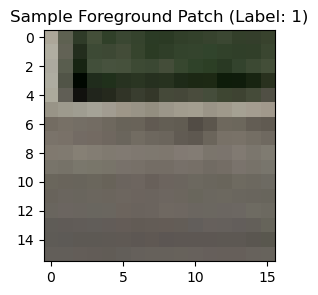

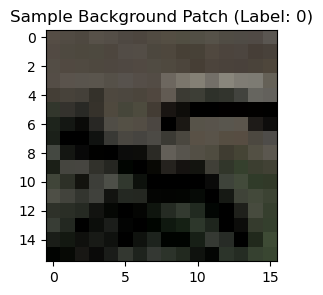

In [55]:
if X.size > 0 and Y.size > 0:
    print(f"Total number of patches: {X.shape[0]}")
    print(f"Feature dimension: {X.shape[1]}") # Should be 12 now
    unique_classes, counts = np.unique(Y, return_counts=True)
    print(f"Classes found: {unique_classes}")
    for cls, count in zip(unique_classes, counts):
        print(f"  Class {cls}: {count} patches ({count*100/X.shape[0]:.2f}%)")

    Y_fg_indices = np.where(Y == 1)[0]
    Y_bg_indices = np.where(Y == 0)[0]

    if len(Y_fg_indices) > 0 :
        plt.figure(figsize=(3,3))
        plt.imshow(img_patches[Y_fg_indices[0]])
        plt.title(f"Sample Foreground Patch (Label: {Y[Y_fg_indices[0]]})")
        plt.show()
    if len(Y_bg_indices) > 0:
        plt.figure(figsize=(3,3))
        plt.imshow(img_patches[Y_bg_indices[0]])
        plt.title(f"Sample Background Patch (Label: {Y[Y_bg_indices[0]]})")
        plt.show()
else:
    print("No data to show statistics or sample patches.")

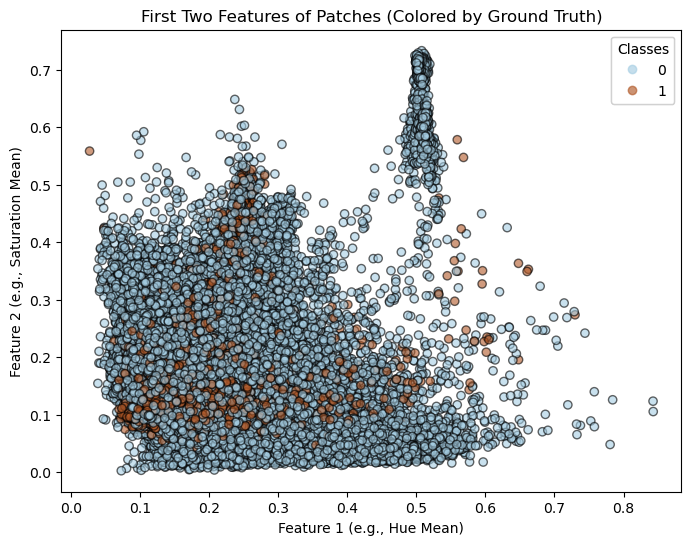

In [56]:
if X.size > 0 and Y.size > 0 and X.shape[1] >= 2: # Check if we have at least 2 features to plot
    plt.figure(figsize=(8, 6))
    # Plotting first two features for simplicity
    scatter = plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', alpha=0.6, cmap=plt.cm.Paired)
    plt.title('First Two Features of Patches (Colored by Ground Truth)')
    plt.xlabel('Feature 1 (e.g., Hue Mean)')
    plt.ylabel('Feature 2 (e.g., Saturation Mean)')
    if hasattr(scatter, 'legend_elements'): # Check if legend_elements can be called
        legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
        plt.gca().add_artist(legend1)
    plt.show()
else:
    print("Not enough features or data to plot the 2D feature scatter.")

In [57]:
if X.size > 0 and Y.size > 0:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)
    print(f"Training set size: {X_train.shape[0]} patches")
    print(f"Test set size: {X_test.shape[0]} patches")
else:
    print("Not enough data to perform train-test split.")
    X_train, X_test, Y_train, Y_test = [np.array([])]*4

Training set size: 46875 patches
Test set size: 15625 patches


In [58]:
if X_train.size > 0:
    print("Training Random Forest Classifier...")
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1)
    rf_classifier.fit(X_train, Y_train)
    print("Training complete.")
else:
    print("No training data available for Random Forest.")
    rf_classifier = None

Training Random Forest Classifier...
Training complete.



Evaluating on the Test Set:

Confusion Matrix:
[[10683   894]
 [ 2191  1857]]


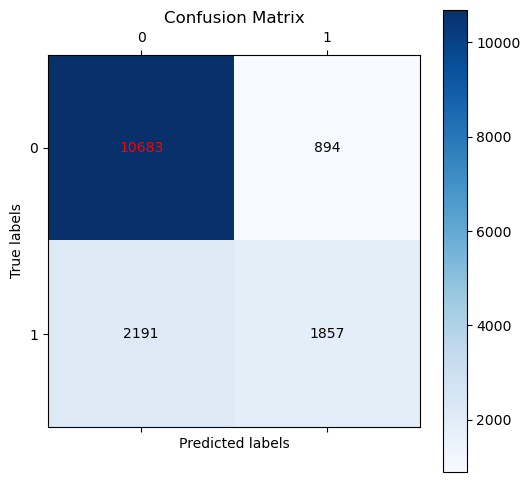


Classification Report (Precision, Recall, F1-score):
                precision    recall  f1-score   support

Background (0)       0.83      0.92      0.87     11577
      Road (1)       0.68      0.46      0.55      4048

      accuracy                           0.80     15625
     macro avg       0.75      0.69      0.71     15625
  weighted avg       0.79      0.80      0.79     15625

F1-score for Road (Class 1): 0.5463


In [59]:
if rf_classifier and X_test.size > 0:
    print("\nEvaluating on the Test Set:")
    Y_pred_test = rf_classifier.predict(X_test)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(Y_test, Y_pred_test)
    print(cm)

    # Fixed plot code
    fig, ax = plt.subplots(figsize=(6,6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # Define ticks and labels
    ticks = np.arange(len(unique_classes))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(unique_classes)
    ax.set_yticklabels(unique_classes)

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), va='center', ha='center', color='red' if cm[i,j] > cm.max()/2 else 'black')
    plt.show()

    print("\nClassification Report (Precision, Recall, F1-score):")
    report = classification_report(Y_test, Y_pred_test, target_names=['Background (0)', 'Road (1)'])
    print(report)
    
    f1 = f1_score(Y_test, Y_pred_test, pos_label=1)
    print(f"F1-score for Road (Class 1): {f1:.4f}")

In [60]:
def label_to_img(imgwidth, imgheight, patch_w, patch_h, labels):
    im = np.zeros([imgwidth, imgheight], dtype=np.uint8)
    idx = 0
    for i_patch_col in range(0, imgheight, patch_h): # Iterate through columns of patches (y-direction)
        for j_patch_row in range(0, imgwidth, patch_w): # Iterate through rows of patches (x-direction)
            if idx < len(labels):
                row_end = min(j_patch_row + patch_w, imgwidth)
                col_end = min(i_patch_col + patch_h, imgheight)
                im[j_patch_row:row_end, i_patch_col:col_end] = labels[idx] * 255
                idx += 1
            else:
                # This case should ideally not be hit if cropping and label generation are correct
                # print(f"Warning: Ran out of labels at patch index {idx} for image size {imgwidth}x{imgheight}")
                break 
        if idx >= len(labels) and idx > 0 :
            break
    return im

def make_img_overlay(img, predicted_mask_bw):
    if img.dtype != np.uint8:
        if np.max(img) <= 1.0 and img.dtype in [np.float32, np.float64]:
             img_uint8 = (img * 255).astype(np.uint8)
        else:
             img_uint8 = img.astype(np.uint8)
    else:
        img_uint8 = img.copy()

    # Ensure original image is 3-channel for color overlay
    if len(img_uint8.shape) == 2: # Grayscale
        img_uint8_rgb = np.stack((img_uint8,)*3, axis=-1)
    elif img_uint8.shape[2] == 4: # RGBA
        img_uint8_rgb = img_uint8[:,:,:3]
    else:
        img_uint8_rgb = img_uint8


    if predicted_mask_bw.dtype != np.uint8:
        predicted_mask_bw_uint8 = predicted_mask_bw.astype(np.uint8)
    else:
        predicted_mask_bw_uint8 = predicted_mask_bw
        
    color_mask = np.zeros_like(img_uint8_rgb) # Match shape of RGB image
    color_mask[predicted_mask_bw_uint8 == 255] = [255, 0, 0] # Red for roads

    img_pil = Image.fromarray(img_uint8_rgb)
    overlay_pil = Image.fromarray(color_mask)

    blended_img_pil = Image.blend(img_pil, overlay_pil, alpha=0.4)
    return np.array(blended_img_pil)
    
def cleanup_mask(mask):
    """ Cleans up a binary mask using morphological operations. Assumes mask is 0 or 255. """
    # Convert to boolean (0 or 1) for skimage morphology functions
    mask_bool = mask > 128 # Threshold to get boolean mask
    
    selem = disk(1) # Structuring element, size can be tuned. 1 is less aggressive.
    
    opened_mask_bool = opening(mask_bool, selem)
    cleaned_mask_bool = closing(opened_mask_bool, selem)
    
    return (cleaned_mask_bool * 255).astype(np.uint8) # Convert back to 0 or 255

print("Mask cleanup function 'cleanup_mask' is defined.")

Mask cleanup function 'cleanup_mask' is defined.



Predicting on image for display: training/images/satImage_001.png


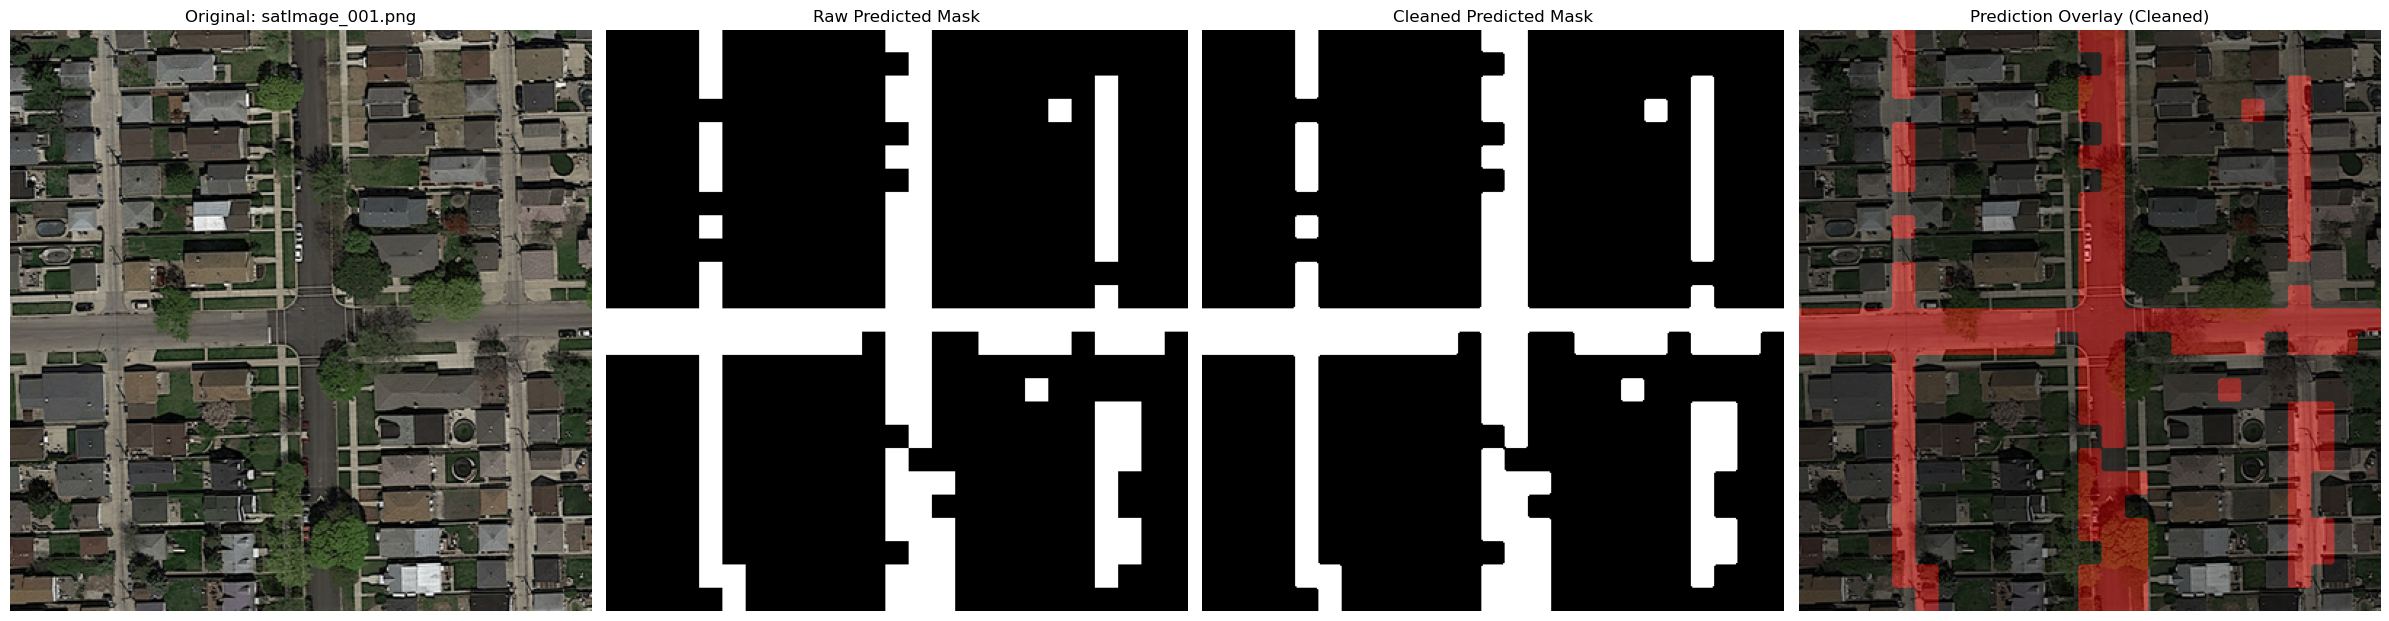

In [61]:
if 'valid_files' in locals() and rf_classifier:
    # Try to pick an image not in the first 'n' used for strict training (if more available)
    # Or, for demonstration, pick one of the loaded images (e.g., the first one, index 0)
    # This will show how the model performs on an image it might have seen patches from (if n covers all images)
    # or a truly unseen one if n is smaller than total valid_files.
    
    pred_img_display_idx = 0 # Display prediction for the first loaded image
    if pred_img_display_idx < len(loaded_filenames):
        image_to_predict_path = os.path.join(image_dir, loaded_filenames[pred_img_display_idx])
        print(f"\nPredicting on image for display: {image_to_predict_path}")

        X_new_img_features, _, original_new_img = extract_img_features(image_to_predict_path, extract_hsv_rgb_features)
        
        if X_new_img_features.size > 0:
            Z_new_img_labels = rf_classifier.predict(X_new_img_features)
            
            predicted_mask_raw = label_to_img(original_new_img.shape[0], original_new_img.shape[1], 
                                          patch_size, patch_size, Z_new_img_labels)
            
            # MODIFICATION: Apply cleanup
            cleaned_prediction_mask = cleanup_mask(predicted_mask_raw)

            # MODIFICATION: Use cleaned mask for overlay
            overlay_image = make_img_overlay(original_new_img, cleaned_prediction_mask)

            # MODIFICATION: Display raw, cleaned, and overlay
            fig, axes = plt.subplots(1, 4, figsize=(24, 8))
            
            axes[0].imshow(original_new_img)
            axes[0].set_title(f"Original: {loaded_filenames[pred_img_display_idx]}")
            axes[0].axis('off')

            axes[1].imshow(predicted_mask_raw, cmap='gray')
            axes[1].set_title("Raw Predicted Mask")
            axes[1].axis('off')

            axes[2].imshow(cleaned_prediction_mask, cmap='gray')
            axes[2].set_title("Cleaned Predicted Mask")
            axes[2].axis('off')

            axes[3].imshow(overlay_image)
            axes[3].set_title("Prediction Overlay (Cleaned)")
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not extract patches/features from {image_to_predict_path}")
    else:
        print(f"Not enough unique images available for display prediction (index {pred_img_display_idx} out of bounds for {len(loaded_filenames)}).")
elif not rf_classifier:
    print("\nModel not trained. Skipping prediction on a new image for display.")
else:
    print("\nNot enough images loaded or 'valid_files' not defined. Skipping display prediction.")


Displaying predictions for the first 3 test images...

Predicting on: test_set_images/test_1/test_1.png


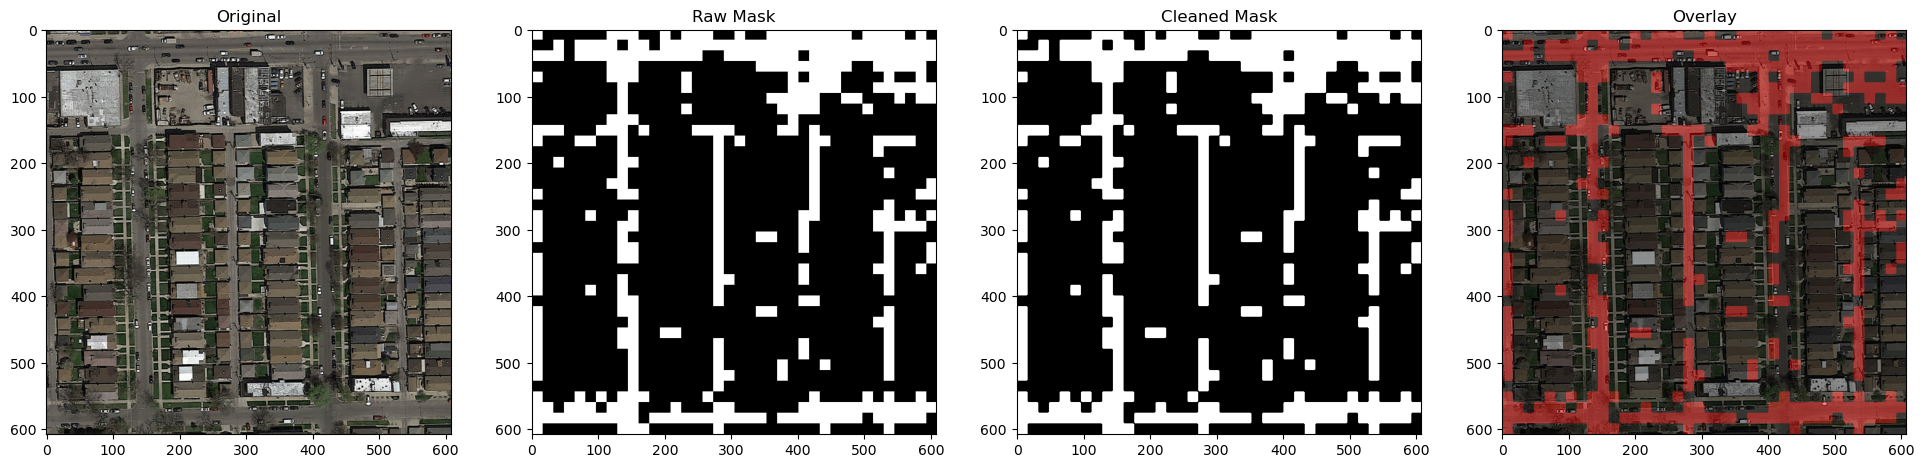


Predicting on: test_set_images/test_2/test_2.png


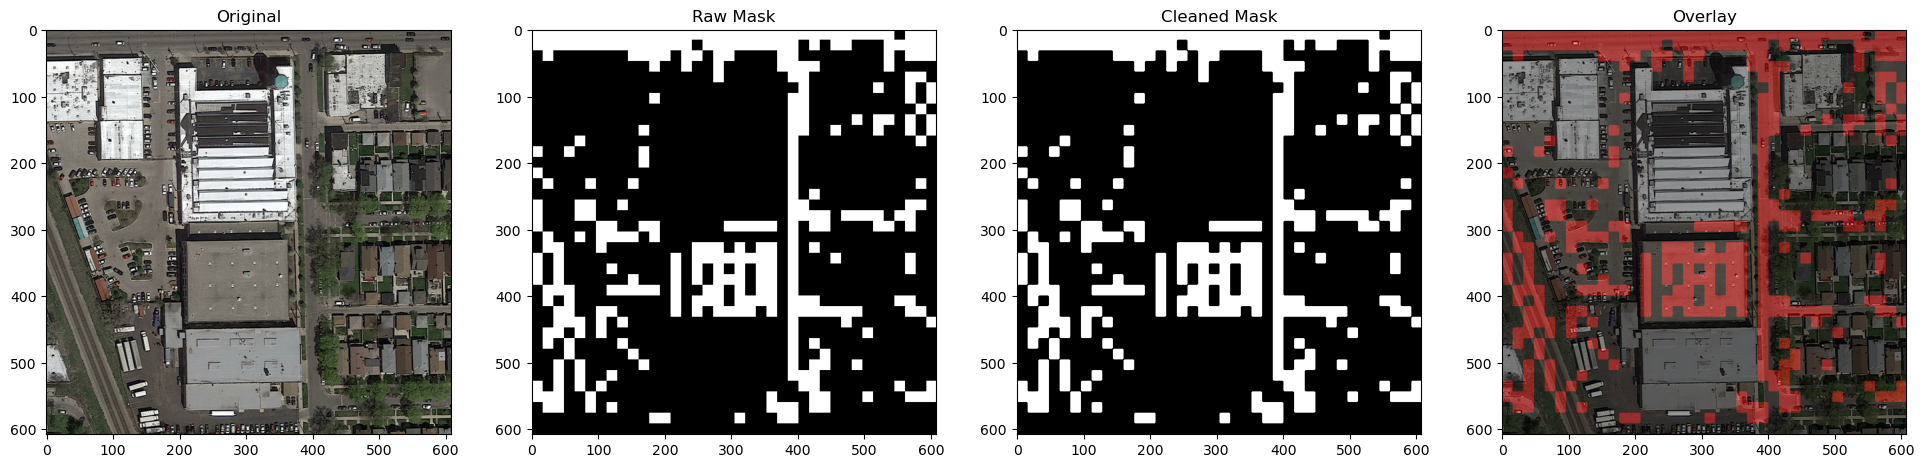


Predicting on: test_set_images/test_3/test_3.png


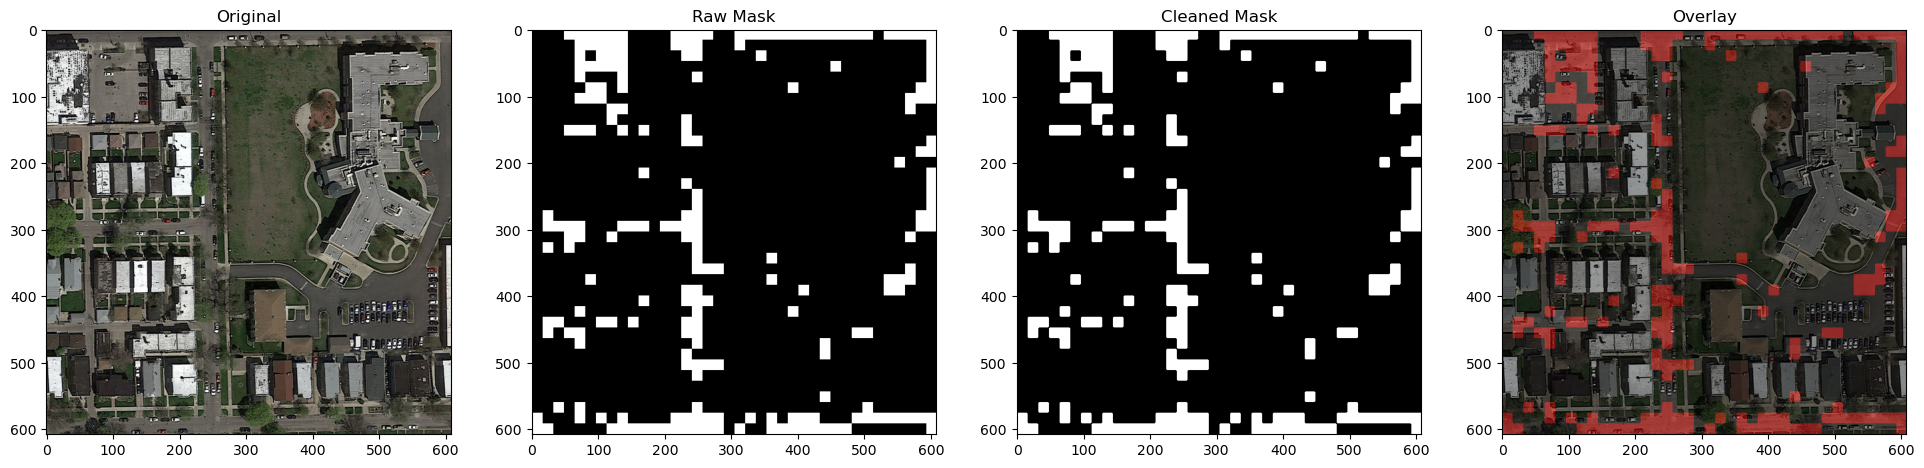

In [62]:
# --- Corrected Cell for Visualizing Test Set Predictions ---

if rf_classifier:
    test_image_base_dir = "test_set_images/"
    num_test_images = 50
    test_files = [os.path.join(test_image_base_dir, f"test_{i}", f"test_{i}.png") for i in range(1, num_test_images + 1)]
    valid_test_files = [f for f in test_files if os.path.exists(f)]
    
    num_to_display = min(3, len(valid_test_files))
    print(f"\nDisplaying predictions for the first {num_to_display} test images...")

    for i in range(num_to_display):
        image_path = valid_test_files[i]
        print(f"\nPredicting on: {image_path}")

        # --- FIX IS HERE ---
        # Use the 12-feature function to match the trained model
        X_new, _, original_img = extract_img_features(image_path, extract_hsv_rgb_features)
        
        if X_new.size > 0:
            Z_labels = rf_classifier.predict(X_new)
            predicted_mask_raw = label_to_img(original_img.shape[0], original_img.shape[1], patch_size, patch_size, Z_labels)
            
            # Use the cleanup function (since scikit-image is now working)
            cleaned_prediction_mask = cleanup_mask(predicted_mask_raw)
            overlay = make_img_overlay(original_img, cleaned_prediction_mask)

            # Display the results
            fig, axes = plt.subplots(1, 4, figsize=(24, 8))
            axes[0].imshow(original_img)
            axes[0].set_title("Original")
            axes[1].imshow(predicted_mask_raw, cmap='gray')
            axes[1].set_title("Raw Mask")
            axes[2].imshow(cleaned_prediction_mask, cmap='gray')
            axes[2].set_title("Cleaned Mask")
            axes[3].imshow(overlay)
            axes[3].set_title("Overlay")
            plt.show()

else:
    print("\nModel not trained. Skipping prediction visualization.")

In [63]:
if rf_classifier:
    test_image_base_dir = "test_set_images/" # Base directory for test images
    
    # Construct paths like "test_set_images/test_1/test_1.png", "test_set_images/test_2/test_2.png"
    num_test_images = 50 # As per user description
    test_files = []
    for i in range(1, num_test_images + 1):
        img_name = f"test_{i}.png"
        img_subdir = f"test_{i}"
        path = os.path.join(test_image_base_dir, img_subdir, img_name)
        if os.path.exists(path):
            test_files.append(path)
        else:
            print(f"Warning: Test image not found at {path}")
            
    test_files.sort() # Ensure consistent order based on path string
    
    print(f"\nFound {len(test_files)} test images to predict for submission.")
    
    submission_entries = []
    if len(test_files) > 0:
        for test_file_path in test_files:
            print(f"Processing {test_file_path} for submission...")
            
            # Extract image ID (number) from path
            # e.g. "test_set_images/test_1/test_1.png" -> "test_1" (subdir name) -> 1
            try:
                subdir_name = os.path.basename(os.path.dirname(test_file_path)) # e.g. "test_1"
                img_number = int(subdir_name.split('_')[1])
            except (IndexError, ValueError) as e:
                print(f"Could not parse image number from path {test_file_path}: {e}. Skipping.")
                continue

            X_test_img_features, _, test_img_original = extract_img_features(test_file_path, extract_hsv_rgb_features)
            
            if X_test_img_features.size > 0:
                Z_test_img_labels = rf_classifier.predict(X_test_img_features)
                
                predicted_mask_raw = label_to_img(test_img_original.shape[0], test_img_original.shape[1], 
                                              patch_size, patch_size, Z_test_img_labels)
                cleaned_mask = cleanup_mask(predicted_mask_raw)
                
                # Normalize cleaned_mask to 0 or 1 for patch labeling
                cleaned_mask_normalized = (cleaned_mask / 255).astype(np.uint8)
                
                # Generate patch-based labels for the submission file
                # The submission format is 'id,prediction' -> 'imageId_rowIndex_colIndex,label'
                # The README implies imageId is just the number.
                # Patches are 16x16.
                for r_idx in range(0, test_img_original.shape[0], patch_size): # row index of top-left corner
                    for c_idx in range(0, test_img_original.shape[1], patch_size): # col index of top-left corner
                        patch_from_mask = cleaned_mask_normalized[r_idx:r_idx+patch_size, c_idx:c_idx+patch_size]
                        # Determine label for the patch based on majority or mean
                        # If >50% of pixels in the patch are 1, label as 1.
                        label = 1 if np.mean(patch_from_mask) > 0.5 else 0
                        
                        # Format: imageId_rowIndex_colIndex (as per sampleSubmission.csv structure)
                        # The sampleSubmission.csv has entries like "001_0_0"
                        # Ensure your img_number matches this if it needs leading zeros (e.g. for Kaggle).
                        # For this project, let's use the raw number as derived.
                        submission_id = f"{img_number}_{r_idx}_{c_idx}"
                        submission_entries.append({
                            "id": submission_id,
                            "prediction": label
                        })
            else:
                print(f"Warning: No features extracted for {test_file_path}. Adding empty predictions for its patches.")
                # If no features, assume all background for this image (or handle as error)
                test_img_dims_fallback = load_image(test_file_path).shape
                for r_idx in range(0, test_img_dims_fallback[0], patch_size):
                    for c_idx in range(0, test_img_dims_fallback[1], patch_size):
                        submission_id = f"{img_number}_{r_idx}_{c_idx}"
                        submission_entries.append({"id": submission_id, "prediction": 0})


        if submission_entries:
            submission_df = pd.DataFrame(submission_entries)
            submission_filename = 'submission.csv'
            submission_df.to_csv(submission_filename, index=False)
            print(f"\nSuccessfully created submission file: '{submission_filename}' with {len(submission_df)} entries.")
            print("Sample entries from submission file:")
            print(submission_df.head())
        else:
            print("No submission entries generated.")
            
    else:
        print("No test files found to generate submission.")
elif not rf_classifier:
    print("\nModel not trained. Skipping submission file generation.")

print("\n--- Notebook Execution Finished ---")


Found 50 test images to predict for submission.
Processing test_set_images/test_1/test_1.png for submission...
Processing test_set_images/test_10/test_10.png for submission...
Processing test_set_images/test_11/test_11.png for submission...
Processing test_set_images/test_12/test_12.png for submission...
Processing test_set_images/test_13/test_13.png for submission...
Processing test_set_images/test_14/test_14.png for submission...
Processing test_set_images/test_15/test_15.png for submission...
Processing test_set_images/test_16/test_16.png for submission...
Processing test_set_images/test_17/test_17.png for submission...
Processing test_set_images/test_18/test_18.png for submission...
Processing test_set_images/test_19/test_19.png for submission...
Processing test_set_images/test_2/test_2.png for submission...
Processing test_set_images/test_20/test_20.png for submission...
Processing test_set_images/test_21/test_21.png for submission...
Processing test_set_images/test_22/test_22.pn